In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)

from xgboost import XGBClassifier
import joblib

In [2]:
# Load featured data
DATA_PATH = "../../data/featured-data.csv"
df = pd.read_csv(DATA_PATH)
df.head()

,Marital status,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Target
0,1,1,1,122.0,127.3,1,0,0,1,1,0,20,0,0.000000,0,0.000000,0,0
1,1,1,1,160.0,142.5,1,0,0,0,1,0,19,6,14.000000,6,13.666667,0,1
2,1,1,1,122.0,124.8,1,0,0,0,1,0,19,0,0.000000,0,0.000000,0,0
3,1,1,1,122.0,119.6,1,0,0,1,0,0,20,6,13.428571,5,12.400000,0,1
4,2,0,1,100.0,141.5,0,0,0,1,0,0,45,5,12.333333,6,13.000000,0,1


In [3]:
# Dataset Info
print("Shape:", df.shape)
df.info()

Shape: (3630, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3630 entries, 0 to 3629
Data columns (total 18 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  3630 non-null   int64  
 1   Daytime/evening attendance	                     3630 non-null   int64  
 2   Previous qualification                          3630 non-null   int64  
 3   Previous qualification (grade)                  3630 non-null   float64
 4   Admission grade                                 3630 non-null   float64
 5   Displaced                                       3630 non-null   int64  
 6   Educational special needs                       3630 non-null   int64  
 7   Debtor                                          3630 non-null   int64  
 8   Tuition fees up to date                         3630 non-null   int64  
 9   Gender                 

In [4]:
# Prepare Features and Target
target_col = "Target"

X = df.drop(columns=[target_col])
y = df[target_col]

In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (2722, 17)
Test size: (908, 17)


In [6]:
# Pipeline setup
pipeline = Pipeline([
    ("model", XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

In [7]:
# hyperparameters for XGBoost
param_grid = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 5, 7],
    'model__subsample': [0.8, 1.0]
}

In [8]:
# Grid Search CV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

In [9]:
# Train model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [20:16:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',
                                                      feature_types=None,
                                                      feature_weights=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=No...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.1, 0.2],
                         'model__max_depth': [3, 5, 7],
                         'model__n_estimators': [100, 200],
                         'model__subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [10]:
# Best Model & Best Parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Parameters:\n", best_params)

Best Parameters:
 {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__subsample': 1.0}


In [11]:
# Results DataFrame
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.258598,0.025493,0.023181,0.002781,0.01,3,100,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.866055,0.895413,0.886029,0.898897,0.884191,0.886117,0.011454,31
1,0.194846,0.017716,0.019785,0.001719,0.01,3,100,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.864220,0.895413,0.882353,0.898897,0.884191,0.885015,0.012174,34
2,0.423866,0.012390,0.021383,0.002575,0.01,3,200,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.867890,0.893578,0.893382,0.902574,0.889706,0.889426,0.011573,27
3,0.339532,0.005974,0.022182,0.001719,0.01,3,200,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.866055,0.893578,0.893382,0.906250,0.887868,0.889427,0.013150,26
4,0.390672,0.078572,0.029576,0.013883,0.01,5,100,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.866055,0.902752,0.893382,0.895221,0.893382,0.890159,0.012538,22


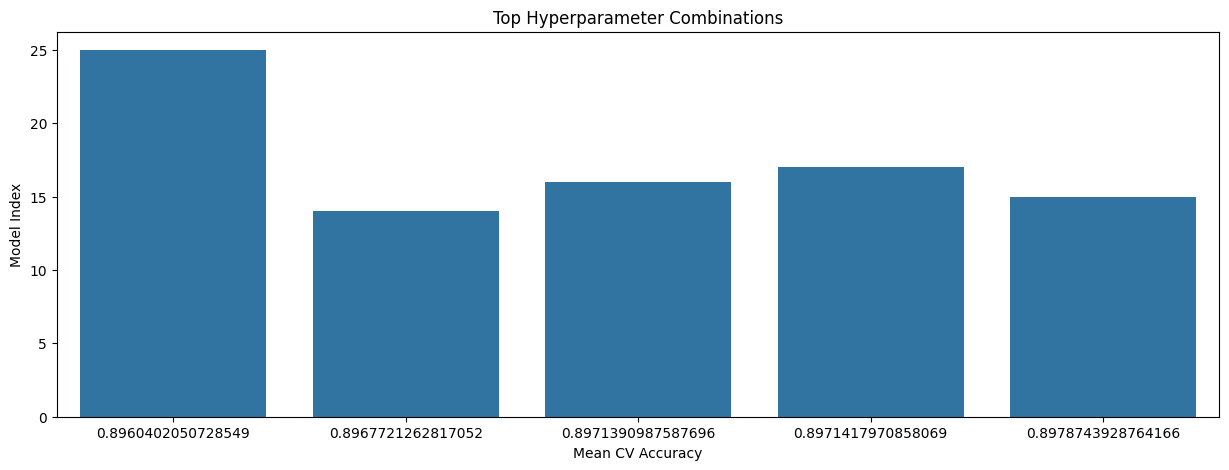

In [19]:
# best vs worst model comparison
top_models = cv_results.sort_values(
    by="mean_test_score",
    ascending=False
).head(5)

plt.figure(figsize=(15, 5))
sns.barplot(
    data=top_models,
    x="mean_test_score",
    y=top_models.index
)
plt.title("Top Hyperparameter Combinations")
plt.xlabel("Mean CV Accuracy")
plt.ylabel("Model Index")
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_4904\1412650811.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_5_results, x='mean_test_score', y='params_str', palette='magma')


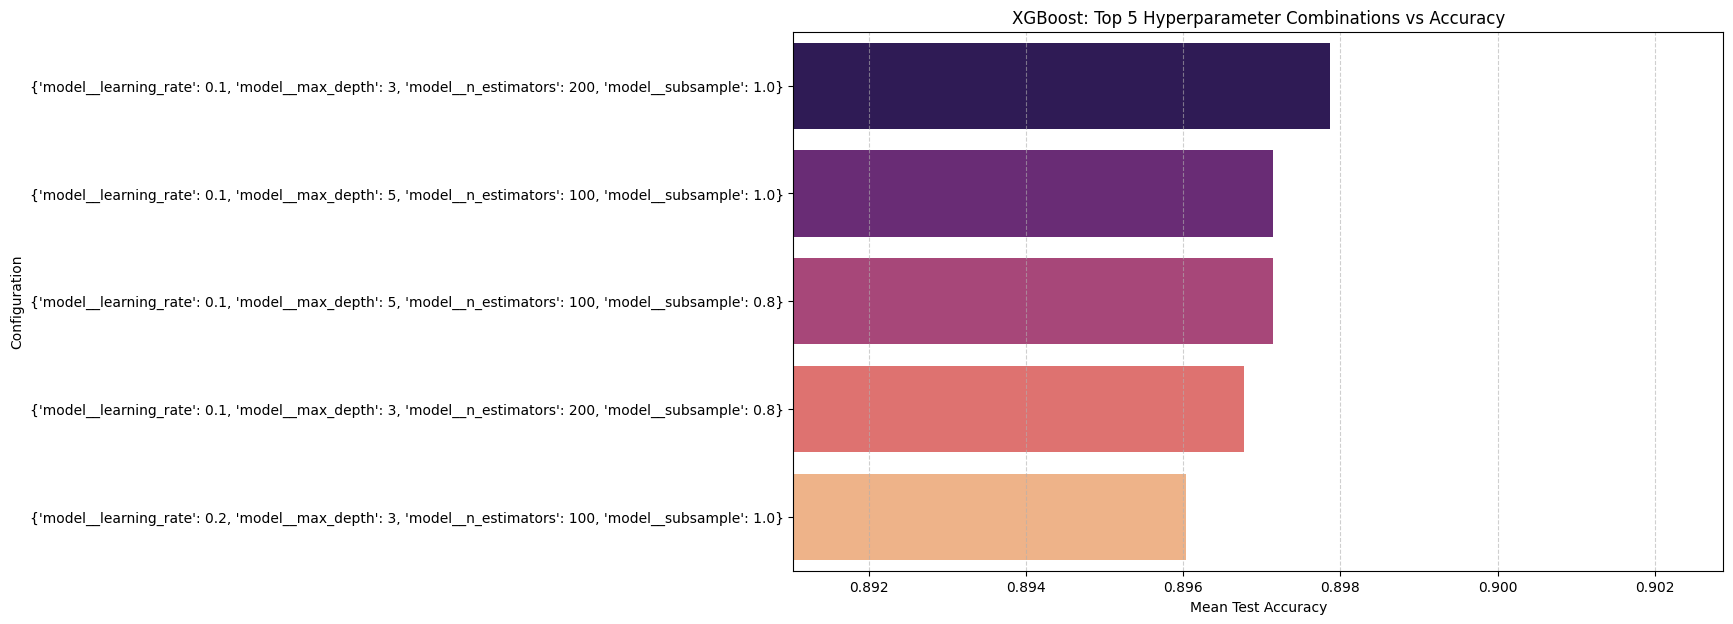

In [13]:
# result dataframe for all combinations
results_df = pd.DataFrame(grid_search.cv_results_)
top_5_results = results_df.nlargest(5, 'mean_test_score')

# Convert params to string for better visualization
top_5_results['params_str'] = top_5_results['params'].apply(lambda x: str(x))

plt.figure(figsize=(12, 7))
sns.barplot(data=top_5_results, x='mean_test_score', y='params_str', palette='magma')
plt.xlim(top_5_results['mean_test_score'].min() - 0.005, top_5_results['mean_test_score'].max() + 0.005)
plt.title('XGBoost: Top 5 Hyperparameter Combinations vs Accuracy')
plt.xlabel('Mean Test Accuracy')
plt.ylabel('Configuration')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

In [14]:
# Evaluate on Test Set
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.8997797356828194

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.82      0.86       355
           1       0.89      0.95      0.92       553

    accuracy                           0.90       908
   macro avg       0.90      0.88      0.89       908
weighted avg       0.90      0.90      0.90       908



C:\Users\Admin\AppData\Local\Temp\ipykernel_4904\4192630715.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df.head(10), x='Importance', y='Feature', palette='viridis')


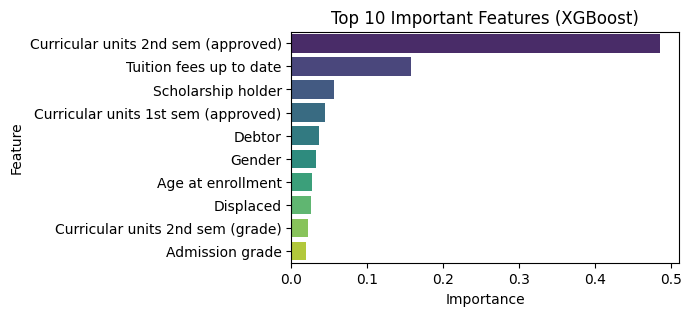

In [15]:
# Model se feature importance nikaalna
importances = best_model.named_steps['model'].feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(5, 3))
sns.barplot(data=feature_importance_df.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Important Features (XGBoost)')
plt.show()

In [16]:
# save test data
joblib.dump(X_test, "../../models & test data/xgboost/xgboost-X_test.pkl")
joblib.dump(y_test, "../../models & test data/xgboost/xgboost-y_test.pkl")

['../../models & test data/xgboost/xgboost-y_test.pkl']

In [17]:
# save best model
joblib.dump(best_model, "../../models & test data/xgboost/xgboost-model.pkl")

['../../models & test data/xgboost/xgboost-model.pkl']